# Multiplexing Pixels Experiments

## Generating multiplexed dataset

[320, 320]
tensor(4, device='cuda:0', dtype=torch.int32)
tensor(0.0050, device='cuda:0') tensor(1., device='cuda:0')


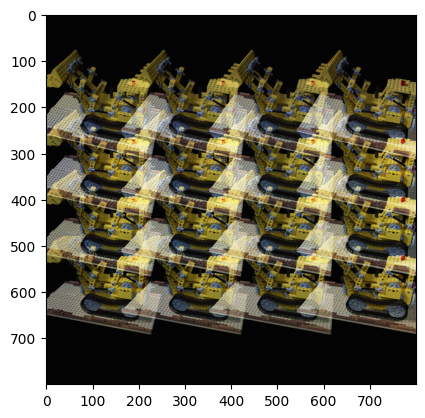

tensor(0., device='cuda:0') tensor(0.6553, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0076, device='cuda:0') tensor(1., device='cuda:0')


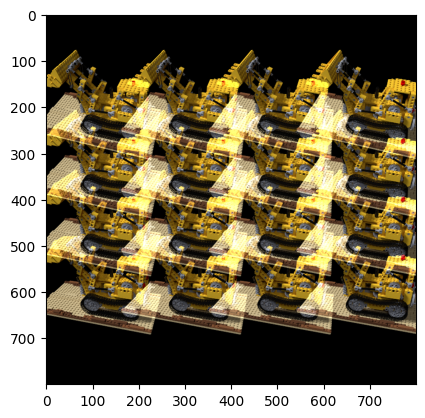

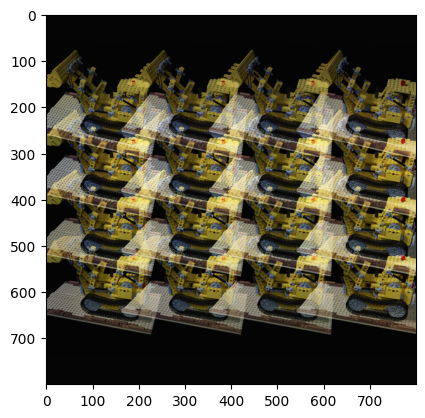

In [52]:
import math
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from kornia.enhance import equalize_clahe

def get_comap(num_lens, d_lens_sensor, H, W):
    if math.sqrt(num_lens)**2 == num_lens:
        num_lenses_yx = [int(math.sqrt(num_lens)), int(math.sqrt(num_lens))]
    else:
        print('Number of sublens should be a square number')
        assert False
    
    base_microlens_size = min(H // num_lenses_yx[0], W // num_lenses_yx[1]) // 12
    microlens_height = int(base_microlens_size * d_lens_sensor)
    microlens_height = microlens_height - (microlens_height % 2)  # Make dimensions even for convenience
    microlens_width = microlens_height  # Keep microlenses square
    comap_yx = -np.ones((num_lens, H, W, 2))
    
    if num_lenses_yx[0] > 1:
        y_positions = np.linspace(
            microlens_height // 2,  # First lens centered at top edge + half lens height
            H - microlens_height // 2,  # Last lens centered at bottom edge - half lens height
            num_lenses_yx[0]
        )
    else: y_positions = np.array([H // 2]) # If only one row, place it in the center
    if num_lenses_yx[1] > 1:
        x_positions = np.linspace(
            microlens_width // 2,  # First lens centered at left edge + half lens width
            W - microlens_width // 2,  # Last lens centered at right edge - half lens width
            num_lenses_yx[1]
        )
    else: x_positions = np.array([W // 2]) # If only one column, place it in the center
    
    for i in range(num_lens):
        row, col = i // num_lenses_yx[1], i % num_lenses_yx[1]        
        center_y, center_x = int(y_positions[row]), int(x_positions[col])
        start_y = int(max(0, center_y - microlens_height // 2))
        end_y = int(min(H, center_y + microlens_height // 2))
        start_x = int(max(0, center_x - microlens_width // 2))
        end_x = int(min(W, center_x + microlens_width // 2))
        
        for y in range(start_y, end_y):
            for x in range(start_x, end_x):
                local_y, local_x = y - start_y, x - start_x
                comap_yx[i, y, x, 0] = local_y
                comap_yx[i, y, x, 1] = local_x
    
    dim_lens_lf_yx = [microlens_height, microlens_width]
    return comap_yx, dim_lens_lf_yx

def read_images(num_lens, model_path, base):
    images = []
    for j in range(num_lens):
        sub_lens_path = f"r_{base}_{j}.png"
        im_gt = imageio.imread(f'{model_path}/{sub_lens_path}').astype(np.float32) / 255.0
        im_tensor = torch.from_numpy(im_gt[:, :, :3]).permute(2, 0, 1).to(device)
        images.append(im_tensor)  # Keep only RGB channels

    return images

def get_max_overlap(comap_yx, num_lens, H, W):
    overlap_count = torch.zeros(H, W, dtype=torch.int32, device=device)
    for i in range(num_lens):
        valid_mask = (comap_yx[i][:,:,1] != -1)
        overlap_count += valid_mask
    return overlap_count.max()

def generate_sub_images(images, comap_yx, dim_lens_lf_yx, num_lens, sensor_size):
    sub_images = torch.zeros(num_lens, 3, sensor_size, sensor_size, device=device, dtype=torch.float32)
    
    # Create a mapping from comap_yx index to images index
    grid_size = int(math.sqrt(num_lens))
    idx = torch.arange(grid_size, device=device)
    grid_i, grid_j = torch.meshgrid(idx, idx, indexing='ij')
    mapping = ((grid_size - 1 - grid_i) + (grid_size - 1 - grid_j) * grid_size).reshape(-1)
    
    images_tensor = torch.stack(images, dim=0).to(device)
    selected_images = images_tensor[mapping]
    resized_images = F.interpolate(
        selected_images, 
        size=(dim_lens_lf_yx[0], dim_lens_lf_yx[1]), 
        mode='bilinear', 
        align_corners=False
    )
    
    for i in range(num_lens):
        # sub_image = torch.zeros(3, sensor_size, sensor_size, device=device, dtype=torch.float32)
        y_coords = comap_yx[i, :, :, 0]
        x_coords = comap_yx[i, :, :, 1]
        
        valid_mask = (y_coords != -1) & (x_coords != -1) & \
                     (y_coords >= 0) & (y_coords < dim_lens_lf_yx[0]) & \
                     (x_coords >= 0) & (x_coords < dim_lens_lf_yx[1])
        
        if valid_mask.any():
            y_indices, x_indices = torch.where(valid_mask)
            y_src = y_coords[valid_mask].int()
            x_src = x_coords[valid_mask].int()
        sub_images[i, :, y_indices, x_indices] = resized_images[i, :, y_src, x_src]
    
    return sub_images

def plot_sub_images(sub_images, num_lens):
    grid_size = int(np.sqrt(num_lens))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            axes[i, j].imshow(sub_images[idx].cpu().permute(1, 2, 0).numpy())
            axes[i, j].set_title(f"Microlens {idx}")
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

NUM_LENS = 16
SENSOR_SIZE = 800
d_lens_sensor = 20
model_path = "/home/wl757/multiplexed-pixels/plenoxels/blender_data/lego_gen12/train_multilens_16_black"
base = "59"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate coordinate mapping
comap_yx, dim_lens_lf_yx = get_comap(NUM_LENS, d_lens_sensor, SENSOR_SIZE, SENSOR_SIZE)
print(dim_lens_lf_yx)
# plt.imshow(comap_yx[0, :, :, 0])
# plt.colorbar()
# plt.show()
comap_yx = torch.from_numpy(comap_yx).to(device)

# Generate and get sub-images
images = read_images(NUM_LENS, model_path, base)
sub_images = generate_sub_images(images, comap_yx, dim_lens_lf_yx, NUM_LENS, SENSOR_SIZE)
max_overlap = get_max_overlap(comap_yx, NUM_LENS, SENSOR_SIZE, SENSOR_SIZE)
print(max_overlap)

# Plot all sub-images
# plot_sub_images(sub_images, NUM_LENS)
combined = torch.sum(sub_images, axis=0)
combined_divide_max = torch.div(combined, combined.max())
combined_divide_max = equalize_clahe(combined_divide_max, clip_limit=3.0, slow_and_differentiable=True)
print(combined_divide_max.min(), combined_divide_max.max())
plt.imshow(combined_divide_max.cpu().permute(1, 2, 0).numpy()); plt.show()
combined_normalized = torch.sum(sub_images, axis=0) / max_overlap
print(combined_normalized.min(), combined_normalized.max())
combined_normalized = equalize_clahe(combined_normalized, clip_limit=4.0, slow_and_differentiable=True)
combined_normalized /= combined_normalized.max()
print(combined_normalized.min(), combined_normalized.max())
plt.imshow(combined.cpu().permute(1, 2, 0).numpy()); plt.show()
plt.imshow(combined_normalized.cpu().permute(1, 2, 0).numpy()); plt.show()

In [29]:
import torch
from kornia.enhance.equalization import equalize_clahe

with torch.autograd.detect_anomaly():
    img = torch.rand((2, 3, 10, 20), requires_grad=True)
    res = equalize_clahe(img, slow_and_differentiable=True)
    res.sum().backward()
    print(img.grad, img.grad.sum()) 

[152, 152]
tensor(4, device='cuda:0', dtype=torch.int32)


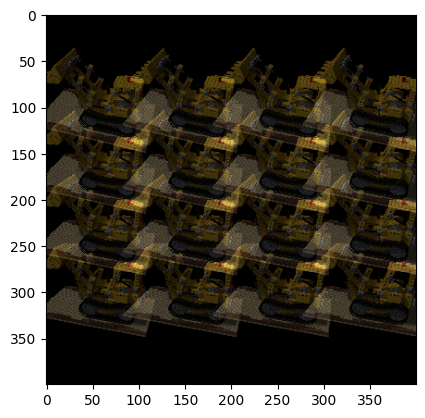

In [7]:
import math
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def get_comap(num_lens, d_lens_sensor, H, W):
    if math.sqrt(num_lens)**2 == num_lens:
        num_lenses_yx = [int(math.sqrt(num_lens)), int(math.sqrt(num_lens))]
    else:
        print('Number of sublens should be a square number')
        assert False
    
    base_microlens_size = min(H // num_lenses_yx[0], W // num_lenses_yx[1]) // 12
    microlens_height = int(base_microlens_size * d_lens_sensor)
    microlens_height = microlens_height - (microlens_height % 2)  # Make dimensions even for convenience
    microlens_width = microlens_height  # Keep microlenses square
    comap_yx = -np.ones((num_lens, H, W, 2))
    
    if num_lenses_yx[0] > 1:
        y_positions = np.linspace(
            microlens_height // 2,  # First lens centered at top edge + half lens height
            H - microlens_height // 2,  # Last lens centered at bottom edge - half lens height
            num_lenses_yx[0]
        )
    else: y_positions = np.array([H // 2]) # If only one row, place it in the center
    if num_lenses_yx[1] > 1:
        x_positions = np.linspace(
            microlens_width // 2,  # First lens centered at left edge + half lens width
            W - microlens_width // 2,  # Last lens centered at right edge - half lens width
            num_lenses_yx[1]
        )
    else: x_positions = np.array([W // 2]) # If only one column, place it in the center
    
    for i in range(num_lens):
        row, col = i // num_lenses_yx[1], i % num_lenses_yx[1]        
        center_y, center_x = int(y_positions[row]), int(x_positions[col])
        start_y = int(max(0, center_y - microlens_height // 2))
        end_y = int(min(H, center_y + microlens_height // 2))
        start_x = int(max(0, center_x - microlens_width // 2))
        end_x = int(min(W, center_x + microlens_width // 2))
        
        for y in range(start_y, end_y):
            for x in range(start_x, end_x):
                local_y, local_x = y - start_y, x - start_x
                comap_yx[i, y, x, 0] = local_y
                comap_yx[i, y, x, 1] = local_x
    
    dim_lens_lf_yx = [microlens_height, microlens_width]
    return comap_yx, dim_lens_lf_yx

def read_images(num_lens, model_path, base):
    images = []
    for j in range(num_lens):
        sub_lens_path = f"r_{base}_{j}.png"
        im_gt = imageio.imread(f'{model_path}/{sub_lens_path}').astype(np.float32) / 255.0
        im_tensor = torch.from_numpy(im_gt[:, :, :3]).permute(2, 0, 1).to(device)
        images.append(im_tensor)  # Keep only RGB channels

    return images

def get_max_overlap(comap_yx, num_lens, H, W):
    overlap_count = torch.zeros(H, W, dtype=torch.int32, device=device)
    for i in range(num_lens):
        valid_mask = (comap_yx[i][:,:,1] != -1)
        overlap_count += valid_mask
    return overlap_count.max()

def generate_sub_images(images, comap_yx, dim_lens_lf_yx, num_lens, sensor_size):
    sub_images = torch.zeros(num_lens, 3, sensor_size, sensor_size, device=device, dtype=torch.float32)
    
    # Create a mapping from comap_yx index to images index
    grid_size = int(math.sqrt(num_lens))
    idx = torch.arange(grid_size, device=device)
    grid_i, grid_j = torch.meshgrid(idx, idx, indexing='ij')
    mapping = ((grid_size - 1 - grid_i) + (grid_size - 1 - grid_j) * grid_size).reshape(-1)
    
    images_tensor = torch.stack(images, dim=0).to(device)
    selected_images = images_tensor[mapping]
    resized_images = F.interpolate(
        selected_images, 
        size=(dim_lens_lf_yx[0], dim_lens_lf_yx[1]), 
        mode='bilinear', 
        align_corners=False
    )
    
    for i in range(num_lens):
        # sub_image = torch.zeros(3, sensor_size, sensor_size, device=device, dtype=torch.float32)
        y_coords = comap_yx[i, :, :, 0]
        x_coords = comap_yx[i, :, :, 1]
        
        valid_mask = (y_coords != -1) & (x_coords != -1) & \
                     (y_coords >= 0) & (y_coords < dim_lens_lf_yx[0]) & \
                     (x_coords >= 0) & (x_coords < dim_lens_lf_yx[1])
        
        if valid_mask.any():
            y_indices, x_indices = torch.where(valid_mask)
            y_src = y_coords[valid_mask].int()
            x_src = x_coords[valid_mask].int()
        sub_images[i, :, y_indices, x_indices] = resized_images[i, :, y_src, x_src]
    
    return sub_images

def plot_sub_images(sub_images, num_lens):
    grid_size = int(np.sqrt(num_lens))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            axes[i, j].imshow(sub_images[idx].cpu().permute(1, 2, 0).numpy())
            axes[i, j].set_title(f"Microlens {idx}")
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

NUM_LENS = 16
SENSOR_SIZE = 400
d_lens_sensor = 19
model_path = "/home/wl757/multiplexed-pixels/plenoxels/blender_data/lego_gen12/train_multilens_16_black"
base = "59"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate coordinate mapping
comap_yx, dim_lens_lf_yx = get_comap(NUM_LENS, d_lens_sensor, SENSOR_SIZE, SENSOR_SIZE)
print(dim_lens_lf_yx)
# plt.imshow(comap_yx[0, :, :, 0])
# plt.colorbar()
# plt.show()
comap_yx = torch.from_numpy(comap_yx).to(device)

# Generate and get sub-images
images = read_images(NUM_LENS, model_path, base)
sub_images = generate_sub_images(images, comap_yx, dim_lens_lf_yx, NUM_LENS, SENSOR_SIZE)
max_overlap = get_max_overlap(comap_yx, NUM_LENS, SENSOR_SIZE, SENSOR_SIZE)
print(max_overlap)

# Plot all sub-images
# plot_sub_images(sub_images, NUM_LENS)
combined = torch.sum(sub_images, axis=0)
combined = combined / combined.max()
plt.imshow(combined.cpu().permute(1, 2, 0).numpy()); plt.show()

[320, 320]


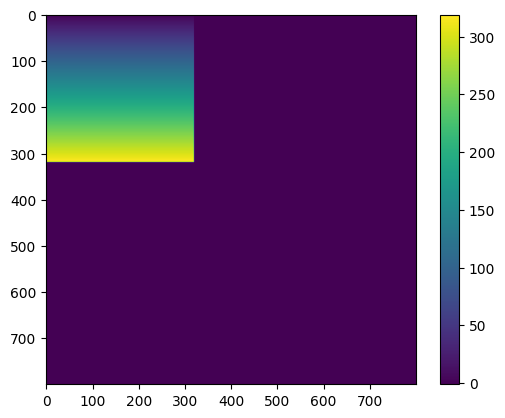

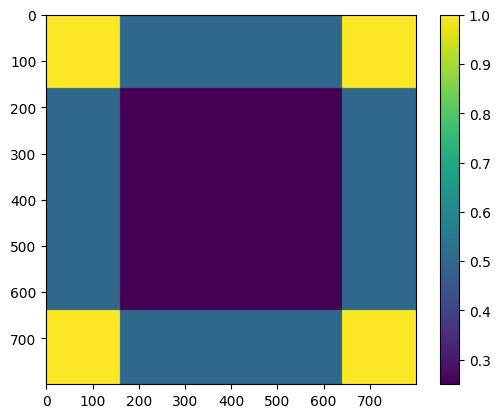

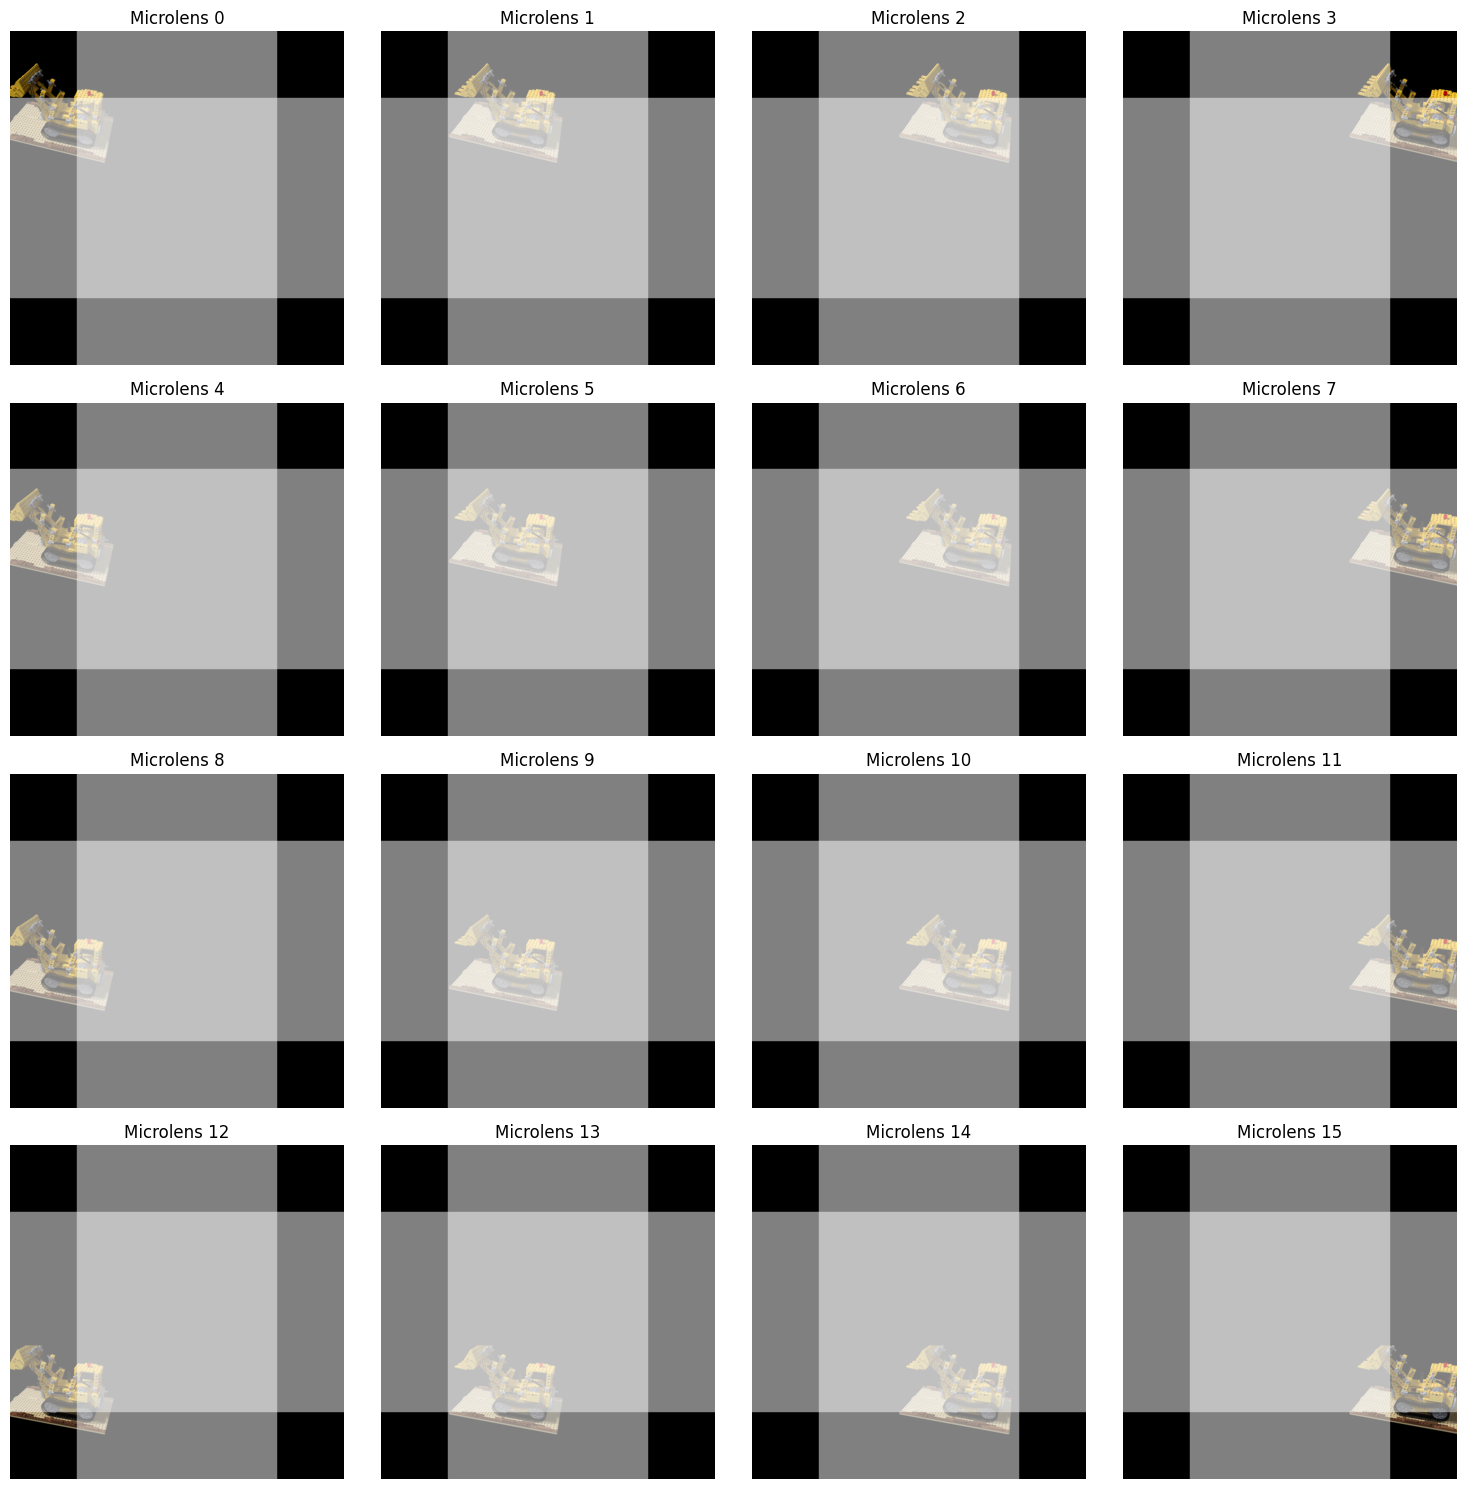

overlap max:  4
overlap min:  1
0.0 0.6284001618623734


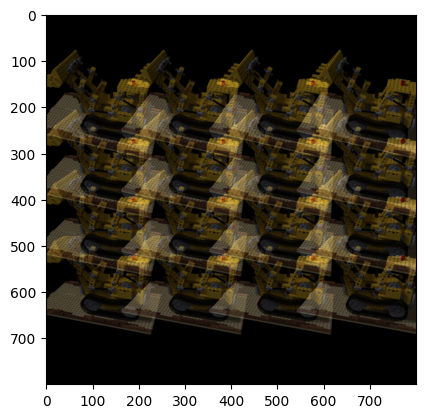

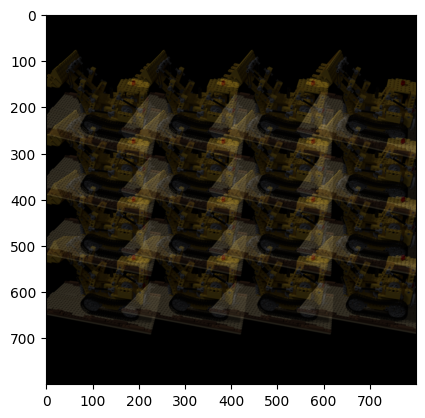

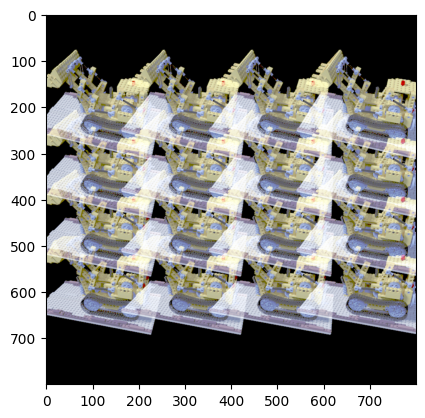

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


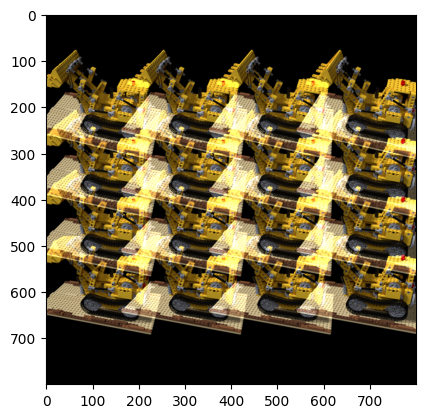

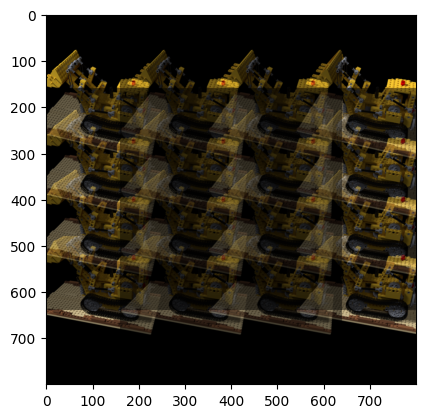

In [ ]:
import math
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from skimage.transform import resize
from kornia import enhance
import torch

def get_comap(num_lens, d_lens_sensor, H, W):
    if math.sqrt(num_lens)**2 == num_lens:
        num_lenses_yx = [int(math.sqrt(num_lens)), int(math.sqrt(num_lens))]
    else:
        print('Number of sublens should be a square number')
        assert False
    
    # Calculate microlens dimensions in pixels based on d_lens_sensor
    base_microlens_size = min(H // num_lenses_yx[0], W // num_lenses_yx[1]) // 12
    microlens_height = int(base_microlens_size * d_lens_sensor)
    microlens_height = microlens_height - (microlens_height % 2)  # Make dimensions even for convenience
    microlens_width = microlens_height  # Keep microlenses square
    comap_yx = -np.ones((num_lens, H, W, 2))
    
    # Calculate positions for microlenses to distribute from edge to edge
    if num_lenses_yx[0] > 1:
        y_positions = np.linspace(
            microlens_height // 2,  # First lens centered at top edge + half lens height
            H - microlens_height // 2,  # Last lens centered at bottom edge - half lens height
            num_lenses_yx[0]
        )
    else: y_positions = np.array([H // 2]) # If only one row, place it in the center
    if num_lenses_yx[1] > 1:
        x_positions = np.linspace(
            microlens_width // 2,  # First lens centered at left edge + half lens width
            W - microlens_width // 2,  # Last lens centered at right edge - half lens width
            num_lenses_yx[1]
        )
    else: x_positions = np.array([W // 2]) # If only one column, place it in the center
    
    for i in range(num_lens):
        row, col = i // num_lenses_yx[1], i % num_lenses_yx[1]        
        center_y, center_x = int(y_positions[row]), int(x_positions[col])
        start_y = int(max(0, center_y - microlens_height // 2))
        end_y = int(min(H, center_y + microlens_height // 2))
        start_x = int(max(0, center_x - microlens_width // 2))
        end_x = int(min(W, center_x + microlens_width // 2))
        
        for y in range(start_y, end_y):
            for x in range(start_x, end_x):
                local_y, local_x = y - start_y, x - start_x
                comap_yx[i, y, x, 0] = local_y
                comap_yx[i, y, x, 1] = local_x
    
    # Return the original dimension as second return value
    dim_lens_lf_yx = [microlens_height, microlens_width]
    return comap_yx, dim_lens_lf_yx

def read_images(num_lens, model_path, base):
    images = []
    for j in range(num_lens):
        sub_lens_path = f"r_{base}_{j}.png"
        im_gt = imageio.imread(f'{model_path}/{sub_lens_path}').astype(np.float32) / 255.0
        images.append(im_gt[:, :, :3])  # Keep only RGB channels
    return images

def generate_alpha_map(comap_yx, num_lens, H, W):
    overlap_count = np.zeros((H, W), dtype=np.int32)
    
    for i in range(num_lens):
        valid_mask = (comap_yx[i, :, :, 0] != -1)
        overlap_count += valid_mask
    
    alpha_map = np.zeros((H, W))
    non_zero_mask = (overlap_count > 0)
    alpha_map[non_zero_mask] = 1.0 / overlap_count[non_zero_mask]
    return alpha_map, overlap_count

def generate_sub_images(images, comap_yx, dim_lens_lf_yx, num_lens, sensor_size):
    sub_images = []
    alpha_map, _ = generate_alpha_map(comap_yx, num_lens, sensor_size, sensor_size)
    
    # Create a mapping from comap_yx index to images index
    grid_size = int(np.sqrt(num_lens))
    mapping = np.zeros(num_lens, dtype=int)
    for i in range(grid_size):
        for j in range(grid_size):
            comap_idx = i * grid_size + j
            images_idx = (grid_size - 1 - i) + (grid_size - 1 - j) * grid_size
            mapping[comap_idx] = images_idx
    
    resized_images = [resize(images[mapping[i]], (dim_lens_lf_yx[0], dim_lens_lf_yx[1]), 
                             anti_aliasing=True) for i in range(num_lens)]
    
    for i in range(num_lens):
        sub_image = np.zeros((sensor_size, sensor_size, 4))
        y_coords = comap_yx[i, :, :, 0]
        x_coords = comap_yx[i, :, :, 1]
        
        valid_mask = (y_coords != -1) & (x_coords != -1)
        
        y_in_bounds = (y_coords >= 0) & (y_coords < dim_lens_lf_yx[0])
        x_in_bounds = (x_coords >= 0) & (x_coords < dim_lens_lf_yx[1])
        valid_mask = valid_mask & y_in_bounds & x_in_bounds
        
        y_indices, x_indices = np.where(valid_mask)
        y_src = y_coords[valid_mask].astype(int)
        x_src = x_coords[valid_mask].astype(int)
        sub_image[y_indices, x_indices, :3] = resized_images[i][y_src, x_src]
        sub_image[:, :, 3] = alpha_map

        sub_images.append(sub_image)
    
    return sub_images

def plot_sub_images(sub_images, num_lens):
    # Calculate grid dimensions (assuming num_lens is a perfect square)
    grid_size = int(np.sqrt(num_lens))
    
    # Create a figure with subplots
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    
    # Plot each sub-image in the correct grid position corresponding to comap_yx ordering
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            axes[i, j].imshow(sub_images[idx])
            axes[i, j].set_title(f"Microlens {idx}")
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()


NUM_LENS = 16
SENSOR_SIZE = 800
d_lens_sensor = 20
model_path = "/home/wl757/multiplexed-pixels/plenoxels/blender_data/lego_gen12/train_multilens_16_black"
base = "59"

# Generate coordinate mapping
comap_yx, dim_lens_lf_yx = get_comap(NUM_LENS, d_lens_sensor, SENSOR_SIZE, SENSOR_SIZE)
# print(dim_lens_lf_yx)
# plt.imshow(comap_yx[0, :, :, 0])
# plt.colorbar()
# plt.show()

alpha_map, overlap_count = generate_alpha_map(comap_yx, NUM_LENS, SENSOR_SIZE, SENSOR_SIZE)
# plt.imshow(alpha_map)
# plt.colorbar()
# plt.show()

# Generate and get sub-images
images = read_images(NUM_LENS, model_path, base)
sub_images = generate_sub_images(images, comap_yx, dim_lens_lf_yx, NUM_LENS, SENSOR_SIZE)

# Plot all sub-images
# plot_sub_images(sub_images, NUM_LENS)
combined = np.sum(sub_images, axis=0)
output = np.zeros((SENSOR_SIZE, SENSOR_SIZE, 3))
for image in sub_images:
    rgb = image[:, :, :3]
    alpha = image[:, :, 3]
    output += rgb * alpha[:, :, np.newaxis]
combined_rgb = combined[:, :, :3]
print("overlap max: ", overlap_count.max())
print("overlap min: ", overlap_count.min())
combined_output = combined_rgb / overlap_count.max()
# combined_output = combined_output / combined_output.max()
print(combined_output.min(), combined_output.max())
plt.imshow(combined_rgb / combined_rgb.max())
plt.show()
plt.imshow(combined_output)
plt.show()
plt.imshow(enhance.equalize(torch.from_numpy(combined_output).permute(2, 0, 1)).permute(1, 2, 0).detach().numpy())
plt.show()
plt.imshow(combined)
plt.show()
plt.imshow(output)
plt.show()

In [ ]:
import math
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from skimage.transform import resize
from timeit import timeit
import torch
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_comap(num_lens, d_lens_sensor, H, W):
    if math.sqrt(num_lens)**2 == num_lens:
        num_lenses_yx = [int(math.sqrt(num_lens)), int(math.sqrt(num_lens))]
    else:
        print('Number of sublens should be a square number')
        assert False
    
    base_microlens_size = min(H // num_lenses_yx[0], W // num_lenses_yx[1]) // 12
    microlens_height = int(base_microlens_size * d_lens_sensor)
    microlens_height = microlens_height - (microlens_height % 2)  # Make dimensions even for convenience
    microlens_width = microlens_height  # Keep microlenses square
    comap_yx = -np.ones((num_lens, H, W, 2))
    
    if num_lenses_yx[0] > 1:
        y_positions = np.linspace(
            microlens_height // 2,  # First lens centered at top edge + half lens height
            H - microlens_height // 2,  # Last lens centered at bottom edge - half lens height
            num_lenses_yx[0]
        )
    else: y_positions = np.array([H // 2]) # If only one row, place it in the center
    if num_lenses_yx[1] > 1:
        x_positions = np.linspace(
            microlens_width // 2,  # First lens centered at left edge + half lens width
            W - microlens_width // 2,  # Last lens centered at right edge - half lens width
            num_lenses_yx[1]
        )
    else: x_positions = np.array([W // 2]) # If only one column, place it in the center
    
    for i in range(num_lens):
        row, col = i // num_lenses_yx[1], i % num_lenses_yx[1]        
        center_y, center_x = int(y_positions[row]), int(x_positions[col])
        start_y = int(max(0, center_y - microlens_height // 2))
        end_y = int(min(H, center_y + microlens_height // 2))
        start_x = int(max(0, center_x - microlens_width // 2))
        end_x = int(min(W, center_x + microlens_width // 2))
        
        for y in range(start_y, end_y):
            for x in range(start_x, end_x):
                local_y, local_x = y - start_y, x - start_x
                comap_yx[i, y, x, 0] = local_y
                comap_yx[i, y, x, 1] = local_x
    
    # Return the original dimension as second return value
    dim_lens_lf_yx = [microlens_height, microlens_width]
    return comap_yx, dim_lens_lf_yx

def read_images(num_lens, model_path, base):
    images = []
    for j in range(num_lens):
        sub_lens_path = f"r_{base}_{j}.png"
        im_gt = imageio.imread(f'{model_path}/{sub_lens_path}').astype(np.float32) / 255.0
        im_tensor = torch.from_numpy(im_gt[:, :, :3]).permute(2, 0, 1).to(device)
        images.append(im_tensor)  # Keep only RGB channels

    return images

def generate_alpha_map(comap_yx, num_lens, H, W):
    overlap_count = np.zeros((H, W), dtype=np.int32)
    
    for i in range(num_lens):
        valid_mask = (comap_yx[i, :, :, 0] != -1)
        overlap_count += valid_mask
    
    alpha_map = np.zeros((H, W))
    non_zero_mask = (overlap_count > 0)
    alpha_map[non_zero_mask] = 1.0 / overlap_count[non_zero_mask]
    return alpha_map

def generate_sub_images(images, comap_yx, dim_lens_lf_yx, num_lens, sensor_size, alpha_map):
    """
    Maps input images to their corresponding locations within each microlens to create
    sub-images of the light field using PyTorch operations.
    
    Parameters:
    -----------
    images : list
        List of PyTorch tensors with shape (3, H, W) containing input images.
    comap_yx : numpy.ndarray
        4D array containing coordinate mapping from get_comap function.
    dim_lens_lf_yx : list
        Dimensions [height, width] of each microlens.
    num_lens : int
        Number of microlenses.
    sensor_size : int
        Size of the output sub-images (both width and height).
        
    Returns:
    --------
    sub_images : list
        List of PyTorch tensors with shape (4, sensor_size, sensor_size) containing 
        the generated sub-images with alpha channel.
    """
    sub_images = []
    
    # Create a mapping from comap_yx index to images index
    grid_size = int(np.sqrt(num_lens))
    mapping = torch.zeros(num_lens, device=device, dtype=torch.long)
    for i in range(grid_size):
        for j in range(grid_size):
            comap_idx = i * grid_size + j
            images_idx = (grid_size - 1 - i) + (grid_size - 1 - j) * grid_size
            mapping[comap_idx] = images_idx
    
    # Resize all images
    resized_images = []
    for i in range(num_lens):
        # Add batch dimension for F.interpolate
        img = images[mapping[i]].unsqueeze(0)
        # F.interpolate expects (B, C, H, W) format
        resized = F.interpolate(
            img, 
            size=(dim_lens_lf_yx[0], dim_lens_lf_yx[1]), 
            mode='bilinear', 
            align_corners=False
        )
        # Remove batch dimension
        resized_images.append(resized.squeeze(0))
    
    for i in range(num_lens):
        # Create an empty sub-image with 4 channels (RGB + alpha)
        sub_image = torch.zeros(4, sensor_size, sensor_size, device=device, dtype=torch.float32)
        
        # Get coordinate maps for this microlens
        y_coords = comap_yx[i, :, :, 0]
        x_coords = comap_yx[i, :, :, 1]
        
        # Create masks for valid coordinates
        valid_mask = (y_coords != -1) & (x_coords != -1)
        y_in_bounds = (y_coords >= 0) & (y_coords < dim_lens_lf_yx[0])
        x_in_bounds = (x_coords >= 0) & (x_coords < dim_lens_lf_yx[1])
        valid_mask = valid_mask & y_in_bounds & x_in_bounds
        
        # Get valid pixel indices
        y_indices, x_indices = torch.where(valid_mask)
        
        if len(y_indices) > 0:  # Check if there are any valid pixels
            # Get corresponding coordinates in the resized image
            y_src = y_coords[valid_mask].long()
            x_src = x_coords[valid_mask].long()
            
            # Map RGB channels from resized image to sub-image
            for c in range(3):
                sub_image[c, y_indices, x_indices] = resized_images[i][c, y_src, x_src]
            
            # Set alpha channel
            sub_image[3, :, :] = alpha_map
        
        sub_images.append(sub_image)
    
    return sub_images

def generate(images, comap_yx, dim_lens_lf_yx, num_lens, sensor_size, alpha_map):
    # Compute the grid size (assumes num_lens is a perfect square)
    grid_size = int(math.sqrt(num_lens))
    
    # Vectorize the mapping from comap_yx index to images index.
    # For each grid coordinate (i, j) in order, the mapping is computed as:
    #   mapping[i * grid_size + j] = (grid_size - 1 - i) + (grid_size - 1 - j) * grid_size
    idx = torch.arange(grid_size, device=device)
    grid_i, grid_j = torch.meshgrid(idx, idx, indexing='ij')
    mapping = ((grid_size - 1 - grid_i) + (grid_size - 1 - grid_j) * grid_size).reshape(-1)
    
    # Stack images into one tensor and select the images as ordered by the mapping.
    # images_tensor shape: (N, 3, H, W) --> selected_images shape: (num_lens, 3, H, W)
    images_tensor = torch.stack(images, dim=0).to(device)
    selected_images = images_tensor[mapping]
    
    # Resize all selected images at once using vectorized interpolation.
    # The output shape will be (num_lens, 3, lens_H, lens_W)
    resized_images = F.interpolate(
        selected_images, 
        size=(dim_lens_lf_yx[0], dim_lens_lf_yx[1]), 
        mode='bilinear', 
        align_corners=False
    )
    
    output_image = torch.zeros(3, sensor_size, sensor_size, device=device, dtype=torch.float32)
    
    # Loop over each microlens and accumulate its contribution.
    for i in range(num_lens):
        # Extract the coordinate maps for this microlens (each of shape (sensor_size, sensor_size)).
        # The last dimension in comap_yx_torch holds [y, x] coordinates.
        y_coords = comap_yx[i, :, :, 0]
        x_coords = comap_yx[i, :, :, 1]
        
        # Build a mask that marks valid pixel positions:
        # - Coordinates must not equal -1
        # - Must be within the bounds of the resized image dimensions.
        valid_mask = (y_coords != -1) & (x_coords != -1) & \
                     (y_coords >= 0) & (y_coords < dim_lens_lf_yx[0]) & \
                     (x_coords >= 0) & (x_coords < dim_lens_lf_yx[1])
        
        # Only process this microlens if there are any valid mapping positions.
        if valid_mask.any():
            # Get 2D indices within the sub-image where valid_mask is True.
            y_indices, x_indices = torch.where(valid_mask)
            
            y_src = y_coords[valid_mask].long()
            x_src = x_coords[valid_mask].long()
            
            output_image[:, y_indices, x_indices] += resized_images[i, :, y_src, x_src] * alpha_map[y_indices, x_indices].unsqueeze(0)
    
    # Clamp the final output to ensure pixel values are in the valid range [0, 1].
    output_image = torch.clamp(output_image, 0, 1)
    
    return output_image

# def generate(images, comap_yx, dim_lens_lf_yx, num_lens, sensor_size, alpha_map):
#     grid_size = int(math.sqrt(num_lens))
#     idx = torch.arange(grid_size, device=device)
#     grid_i, grid_j = torch.meshgrid(idx, idx, indexing='ij')
#     mapping = ((grid_size - 1 - grid_i) + (grid_size - 1 - grid_j) * grid_size).reshape(-1)
    
#     images_tensor = torch.stack(images, dim=0).to(device)
#     selected_images = images_tensor[mapping]
#     resized_images = F.interpolate(
#         selected_images, 
#         size=(dim_lens_lf_yx[0], dim_lens_lf_yx[1]), 
#         mode='bilinear', 
#         align_corners=False
#     )
    
#     output_image = torch.zeros(3, sensor_size, sensor_size, device=device, dtype=torch.float32)
    
#     for i in range(num_lens):
#         y_coords = comap_yx[i, :, :, 0]
#         x_coords = comap_yx[i, :, :, 1]
        
#         valid_mask = (y_coords != -1) & (x_coords != -1) & \
#                      (y_coords >= 0) & (y_coords < dim_lens_lf_yx[0]) & \
#                      (x_coords >= 0) & (x_coords < dim_lens_lf_yx[1])
        
#         # Only process this microlens if there are any valid mapping positions.
#         if valid_mask.any():
#             # Get 2D indices within the sub-image where valid_mask is True.
#             y_indices, x_indices = torch.where(valid_mask)
#             y_src = y_coords[valid_mask].long()
#             x_src = x_coords[valid_mask].long()
#             output_image[:, y_indices, x_indices] += resized_images[i, :, y_src, x_src] * alpha_map[y_indices, x_indices].unsqueeze(0)
    
#     # Clamp the final output to ensure pixel values are in the valid range [0, 1].
#     output_image = torch.clamp(output_image, 0, 1)
    
#     return output_image

mode_path = "/home/wl757/multiplexed-pixels/plenoxels/blender_data/lego_gen12/train_multilens_16_black"
base = "59"
NUM_LENS = 16
SENSOR_SIZE = 800
d_lens_sensor = 20  # this is the value to change for more or less multiplexing

comap_yx, dim_lens_lf_yx = get_comap(NUM_LENS, d_lens_sensor, SENSOR_SIZE, SENSOR_SIZE)
alpha_map = torch.from_numpy(generate_alpha_map(comap_yx, NUM_LENS, SENSOR_SIZE, SENSOR_SIZE)).float().to(device)
plt.imshow(alpha_map.cpu().numpy())
plt.colorbar()
plt.show()
comap_yx = torch.from_numpy(comap_yx).to(device)
images = read_images(NUM_LENS, model_path, base)
# multiplexed_image = generate(images, comap_yx, dim_lens_lf_yx, NUM_LENS, SENSOR_SIZE, alpha_map)
sub_images = generate_sub_images(images, comap_yx, dim_lens_lf_yx, NUM_LENS, SENSOR_SIZE, alpha_map)
for sub_image in sub_images:
    rgb = sub_image[:3]
    alpha = sub_image[3]
    plt.imshow((rgb * alpha).cpu().numpy().transpose(1, 2, 0))
    plt.show()
# plt.imshow(sub_images[5].cpu().numpy().transpose(1, 2, 0))
# plt.show()
# output_image = torch.zeros(3, SENSOR_SIZE, SENSOR_SIZE, device=device, dtype=torch.float32)
# for sub_image in sub_images[5:7]:
#     rgb = sub_image[:3]
#     alpha = sub_image[3]
#     output_image += rgb * alpha
# output_image = torch.clamp(output_image, 0, 1)
# plt.imshow(output_image.cpu().numpy().transpose(1, 2, 0))
# plt.show()

Calculated how the maximum number of rays from microlens that maps to one sensor pixel

In [ ]:
MAX_PER_PIXEL = 20
NUM_LENS= num_lenses_yx[0] * num_lenses_yx[1]
sensor_size = 800

def get_rays_per_pixel(H,W, comap_yx):
    per_pixel = np.zeros((sensor_size,sensor_size,MAX_PER_PIXEL,3)).astype(np.uint32)
    mask = np.zeros((sensor_size,sensor_size,MAX_PER_PIXEL)).astype(float)
    cnt = np.zeros((sensor_size,sensor_size)).astype(np.uint8)
    for a in range(sensor_size):
        for b in range(sensor_size):
            for l in range(NUM_LENS):
                x=comap_yx[l, b, a, 1]
                y=comap_yx[l, b, a, 0]
                if x!=-1 and y!=-1:
                    per_pixel[a,b, cnt[a,b]] = np.array([x,y, l])
                    mask[a,b, cnt[a,b]] = 1.
                    cnt[a,b]+=1
    return per_pixel, mask,cnt
per_pixel, mask,cnt = get_rays_per_pixel(sensor_size,sensor_size, comap_yx)
MAX_PER_PIXEL = np.max(cnt)
print('MAX_PER_PIXEL:',MAX_PER_PIXEL)

MAX_PER_PIXEL: 4


Generate multiplexed images, set dir_name to be the saved directory of multiplexed images, and set selected_views to be a list of view index from transform_train.json, set rendered_views_path to be the directory that contains images from the sublens

319.0


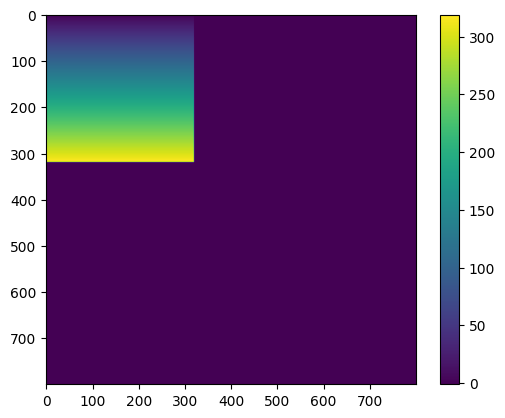

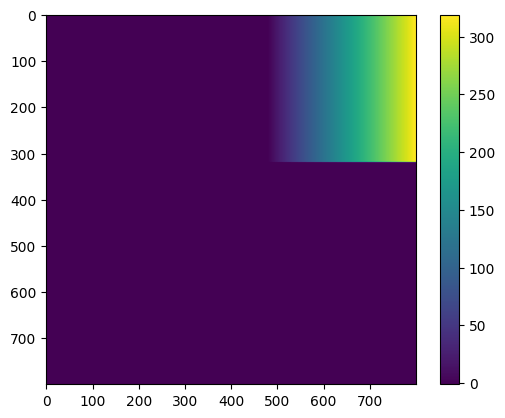

In [ ]:
import math
import random
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from skimage.transform import resize
from PIL import Image
%matplotlib inline
import glob
import os
import json

num_lenses_yx =  [4, 4] #[10,10] #[2,1] #[1,1]# [4,4] #[1,1]# [4,4]
MAX_PER_PIXEL = 20
NUM_LENS = num_lenses_yx[0] * num_lenses_yx[1]
sensor_size = 800
d_lens_sensor = 20  # this is the value to change for more or less multiplexing

def get_comap(num_lens, d_lens_sensor, H, W):
    # Verify input and calculate the grid dimensions
    if math.sqrt(num_lens)**2 == num_lens:
        num_lenses_yx = [int(math.sqrt(num_lens)), int(math.sqrt(num_lens))]
    else:
        print('Number of sublens should be a square number')
        assert False
    
    # Calculate microlens dimensions in pixels based on d_lens_sensor
    base_microlens_size = min(H // num_lenses_yx[0], W // num_lenses_yx[1]) // 12
    microlens_height = int(base_microlens_size * d_lens_sensor)
    microlens_height = microlens_height - (microlens_height % 2)  # Make dimensions even for convenience
    microlens_width = microlens_height  # Keep microlenses square
    comap_yx = -np.ones((num_lens, H, W, 2))
    
    # Calculate positions for microlenses to distribute from edge to edge
    if num_lenses_yx[0] > 1:
        y_positions = np.linspace(
            microlens_height // 2,  # First lens centered at top edge + half lens height
            H - microlens_height // 2,  # Last lens centered at bottom edge - half lens height
            num_lenses_yx[0]
        )
    else: y_positions = np.array([H // 2]) # If only one row, place it in the center
    if num_lenses_yx[1] > 1:
        x_positions = np.linspace(
            microlens_width // 2,  # First lens centered at left edge + half lens width
            W - microlens_width // 2,  # Last lens centered at right edge - half lens width
            num_lenses_yx[1]
        )
    else: x_positions = np.array([W // 2]) # If only one column, place it in the center
    
    for i in range(num_lens):
        row, col = i // num_lenses_yx[1], i % num_lenses_yx[1]        
        center_y, center_x = int(y_positions[row]), int(x_positions[col])
        start_y = int(max(0, center_y - microlens_height // 2))
        end_y = int(min(H, center_y + microlens_height // 2))
        start_x = int(max(0, center_x - microlens_width // 2))
        end_x = int(min(W, center_x + microlens_width // 2))
        
        for y in range(start_y, end_y):
            for x in range(start_x, end_x):
                local_y, local_x = y - start_y, x - start_x
                comap_yx[i, y, x, 0] = local_y
                comap_yx[i, y, x, 1] = local_x
    
    # Return the original dimension as second return value
    dim_lens_lf_yx = [microlens_height, microlens_width]
    return comap_yx, dim_lens_lf_yx
    

comap_yx, _ = get_comap(16, 20, 800, 800)
print(comap_yx.max())
plt.imshow(comap_yx[0, :, :, 0])
plt.colorbar()
plt.show()
plt.imshow(comap_yx[3, :, :, 1])
plt.colorbar()
plt.show()

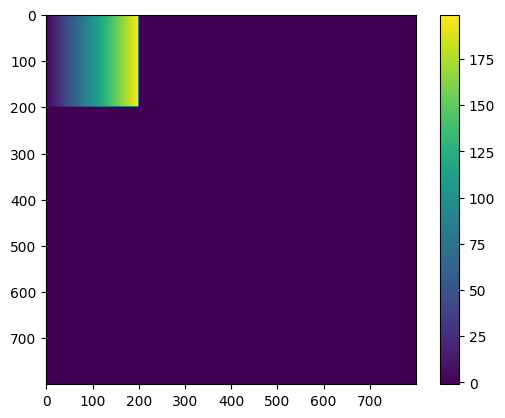

(16, 800, 800, 2)
MAX VALUE 0.9974947571754456
(800, 800, 4)


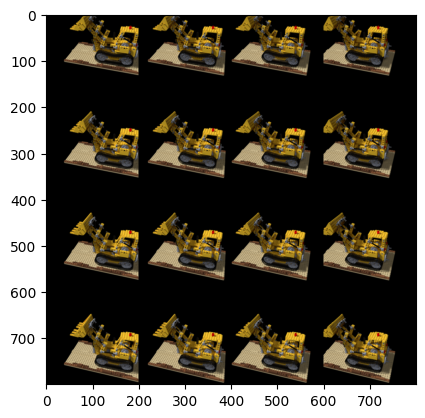

In [ ]:
import math
import random
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from skimage.transform import resize
from PIL import Image
%matplotlib inline
import glob
import os
import json

num_lenses_yx =  [4,4] #[10,10] #[2,1] #[1,1]# [4,4] #[1,1]# [4,4]
MAX_PER_PIXEL = 20
NUM_LENS = num_lenses_yx[0] * num_lenses_yx[1]
sensor_size = 800
d_lens_sensor = 10  # this is the value to change for more or less multiplexing

model_path = "/home/wl757/multiplexed-pixels/plenoxels/blender_data/lego_gen12/train_multilens_16_black"
SUBIMAGES = [x for x in range(16)]

def get_comap(num_lens, d_lens_sensor, H, W):
    dim_yx = [H,W] 
    dx = 0.020  # pixel size in mm
    if math.sqrt(num_lens)**2 == num_lens:
        num_lenses_yx = [int(math.sqrt(num_lens)),int(math.sqrt(num_lens))] 
    else:
        print('Number of sublens should be a square number')
        assert False

    d_lens_sensor_lf = 10  # distance between lens array and sensor when no multiplexing (lightfield), in mm
    dim_lens_lf_yx = [dim_yx[0]//num_lenses_yx[0], dim_yx[0]//num_lenses_yx[0]] # number of pixels corresponding to a microlens at the lightfield situation
    d_lenses = dim_lens_lf_yx[0]*dx # # distance between the centers of adjacent microlenses, in mm

    # d_lens_sensor = FLAGS.d_lens_sensor  # this is the value to change for more or less multiplexing

    # print(f'd_lenses {d_lenses}, dim_lens_lf_yx {dim_lens_lf_yx}, d_lens_sensor {d_lens_sensor}')

    lenses_loc_yx = np.meshgrid((np.arange(num_lenses_yx[0]) - (num_lenses_yx[0]-1)/2) * d_lenses,
                                (np.arange(num_lenses_yx[1]) - (num_lenses_yx[1]-1)/2) * d_lenses, indexing='ij')
    lenses_loc_yx = np.array(lenses_loc_yx).reshape(2, np.prod(num_lenses_yx)).transpose()

    dim_lens_yx = [dim_lens_lf_yx[0] / d_lens_sensor_lf * d_lens_sensor, dim_lens_lf_yx[1] / d_lens_sensor_lf * d_lens_sensor]
    dim_lens_yx = [dim_lens_yx[0] - dim_lens_yx[0]%2, dim_lens_yx[1] - dim_lens_yx[1]%2]  # assuming dim_lens_yx is even
    lens_sensor_ind_yx = np.array(np.meshgrid(np.arange(dim_lens_yx[0]), np.arange(dim_lens_yx[1]), indexing='ij')).transpose((1, 2, 0))

    sensor_pixel_loc_y = (np.arange(dim_yx[0]) - dim_yx[0]/2) * dx
    sensor_pixel_loc_x = (np.arange(dim_yx[1]) - dim_yx[1]/2) * dx

    comap_yx = -np.ones((len(lenses_loc_yx), dim_yx[0], dim_yx[1], 2))  

    for i, lens_loc_yx in enumerate(lenses_loc_yx):
        center_index_yx = [np.argmin(np.abs(lens_loc_yx[0] - sensor_pixel_loc_y)), np.argmin(np.abs(lens_loc_yx[1] - sensor_pixel_loc_x))]
        start_index_sensor_yx = [np.maximum(0, center_index_yx[0] - dim_lens_yx[0]//2).astype(int),
                                 np.maximum(0, center_index_yx[1] - dim_lens_yx[1]//2).astype(int)]
        end_index_sensor_yx = [np.minimum(dim_yx[0], center_index_yx[0] + dim_lens_yx[0]//2).astype(int),
                               np.minimum(dim_yx[1], center_index_yx[1] + dim_lens_yx[1]//2).astype(int)]  

        start_index_lens_yx = [int(dim_lens_yx[0]//2 - center_index_yx[0] + start_index_sensor_yx[0]), 
                               int(dim_lens_yx[1]//2 - center_index_yx[1] + start_index_sensor_yx[1])]
        end_index_lens_yx = [int(dim_lens_yx[0]//2 - center_index_yx[0] + end_index_sensor_yx[0]), 
                             int(dim_lens_yx[1]//2 - center_index_yx[1] + end_index_sensor_yx[1])]

        comap_yx[i, start_index_sensor_yx[0]:end_index_sensor_yx[0], start_index_sensor_yx[1]:end_index_sensor_yx[1], :] = lens_sensor_ind_yx[start_index_lens_yx[0]:end_index_lens_yx[0], start_index_lens_yx[1]:end_index_lens_yx[1],:]
    return comap_yx, dim_lens_lf_yx

def get_rays_per_pixel(H, W, comap_yx, max_per_pixel, num_lens):
    MAX_PER_PIXEL_INIT = 20
    # per_pixel = torch.zeros((H,W,max_per_pixel,3), dtype=torch.int)
    # mask = torch.zeros((H,W,max_per_pixel), dtype=torch.int)
    # cnt_mpp = torch.zeros((H,W), dtype=torch.int)
    
    per_pixel = np.zeros((W,H,max_per_pixel,3)).astype(int)
    mask = np.zeros((W,H,max_per_pixel)).astype(int)
    cnt_mpp = np.zeros((W, H)).astype(int)
    
    # per_pixel = (comap_yx != -1).nonzero(as_tuple=True) #number_of_matches x tensor_dimension
    # print(H, W)
    for l in range(num_lens):
        for a in range(W):
            for b in range(H):
                x=comap_yx[l, b, a, 1]
                y=comap_yx[l, b, a, 0]
                if x!=-1 and y!=-1:
                    per_pixel[a,b, cnt_mpp[a,b]] = np.array([x,y, l])
                    mask[a,b, cnt_mpp[a,b]] = 1.
                    cnt_mpp[a,b]+=1
    return per_pixel , mask, cnt_mpp

def generate(comap_yx, base, model_path, num_lens, H, W):
    rendered_views_path = model_path 
    
    maps_pixel_to_rays, mask, cnt_mpp = get_rays_per_pixel(H,W, comap_yx,20, num_lens)
    MAX_PER_PIXEL = np.max(cnt_mpp)
    maps_pixel_to_rays, mask, cnt_mpp = get_rays_per_pixel(H,W, comap_yx,MAX_PER_PIXEL, num_lens)
    u = int(np.max(comap_yx[0,:,:,:], axis=(0,1,2)) +1)
    sub_lens = np.zeros((num_lens,u,u,3))
    

    for j in range(num_lens):
        sub_lens_path = f"r_{base}_{j}.png"
        im_gt = imageio.imread(f'{rendered_views_path}/{sub_lens_path}').astype(np.float32) / 255.0 
        
        a = int(np.max(comap_yx[0,:,:,:], axis=(0,1,2)))+1
        im_gt = resize(im_gt, (a,a), anti_aliasing=True)
        sub_lens[j,:,:,:] = im_gt[:,:,:3]
        
        
    rgb = np.zeros((H,W,3)).astype(float)
    cnt_subpixels = np.zeros((H,W), dtype=int)
    
    for i_index in range(H):
        for j_index in range(W):
            for cnt_rays in range(maps_pixel_to_rays.shape[2]): # over MAX_PER_PIXEL
                x_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,0] # height
                y_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,1] # width
                l_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,2] # lens
                if mask[i_index, j_index,cnt_rays]==1 and l_index in range(num_lens):
                    rgb[i_index, j_index] += sub_lens[l_index, x_index, y_index,:]
                    cnt_subpixels[i_index, j_index] +=1
            # rgb[i_index,j_index] = rgb[i_index,j_index] / cnt_subpixels[i_index, j_index] +1e-9#MAX_PER_PIXEL 
    print(f"MAX VALUE {np.max(rgb)}")
    max_pixel = np.max(rgb)
    rgb2 = rgb #/np.max(rgb)
    # vis = np.asarray(rgb2 * 255).astype(np.uint8)
    rgb = np.concatenate((rgb2, np.ones((H,W,1))), axis=2)
    im = Image.fromarray(np.uint8(rgb*255))
    return rgb, max_pixel

comap_yx, _ = get_comap(NUM_LENS, d_lens_sensor, sensor_size, sensor_size)
plt.imshow(comap_yx[0, :, :, 1])
plt.colorbar()
plt.show()
print(comap_yx.shape)
rgb, _ = generate(comap_yx, "59", model_path=model_path, num_lens=NUM_LENS, H=sensor_size, W=sensor_size)
print(rgb.shape)
plt.imshow(rgb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.9796679019927979].


MAX VALUE 1.9796679019927979
(800, 800, 4)


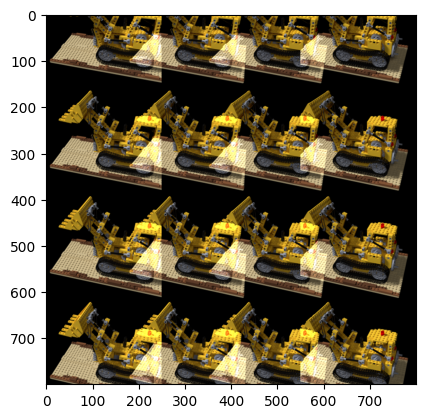

In [ ]:
import math
import random
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from skimage.transform import resize
from PIL import Image
%matplotlib inline
import glob
import os
import json

num_lenses_yx =  [4,4] #[10,10] #[2,1] #[1,1]# [4,4] #[1,1]# [4,4]
MAX_PER_PIXEL = 20
NUM_LENS = num_lenses_yx[0] * num_lenses_yx[1]
sensor_size = 800
d_lens_sensor = 15  # this is the value to change for more or less multiplexing

model_path = "/home/wl757/multiplexed-pixels/plenoxels/blender_data/lego_gen12/train_multilens_16_black"
SUBIMAGES = [x for x in range(16)]

def get_comap(num_lens, d_lens_sensor, H, W):
    """
    Computes a mapping from sensor pixels to lens subimage pixels.
    For each lens, if its intended subimage (given by d_lens_sensor)
    would extend outside the sensor boundaries, we clip the sensor region
    and proportionally reduce the corresponding lens region.
    """
    # Sensor dimensions and pixel size (in mm)
    dim_yx = [H, W] 
    dx = 0.020

    # Ensure the total number of lenses is a square number.
    if math.sqrt(num_lens)**2 == num_lens:
        num_lenses_yx = [int(math.sqrt(num_lens)), int(math.sqrt(num_lens))]
    else:
        raise ValueError('Number of sublens should be a square number')

    # Parameters for the lightfield situation
    d_lens_sensor_lf = 10  # baseline distance (mm) between lens array and sensor
    # For lightfield, each microlens covers a subset of sensor pixels:
    dim_lens_lf_yx = [dim_yx[0] // num_lenses_yx[0], dim_yx[0] // num_lenses_yx[0]]
    d_lenses = dim_lens_lf_yx[0] * dx  # center-to-center spacing in mm

    # Compute the (x,y) positions of microlens centers (in mm)
    lenses_loc_yx = np.meshgrid(
        (np.arange(num_lenses_yx[0]) - (num_lenses_yx[0] - 1) / 2) * d_lenses,
        (np.arange(num_lenses_yx[1]) - (num_lenses_yx[1] - 1) / 2) * d_lenses,
        indexing='ij')
    lenses_loc_yx = np.array(lenses_loc_yx).reshape(2, -1).T

    # Intended size (in pixels) for each lens's contribution AFTER multiplexing.
    # This is scaled from the lightfield case using d_lens_sensor.
    dim_lens_yx = [dim_lens_lf_yx[0] / d_lens_sensor_lf * d_lens_sensor,
                   dim_lens_lf_yx[1] / d_lens_sensor_lf * d_lens_sensor]
    # Force an even number of pixels
    dim_lens_yx = [dim_lens_yx[0] - dim_lens_yx[0] % 2, dim_lens_yx[1] - dim_lens_yx[1] % 2]

    # Create the full grid of indices for a microlens subimage.
    lens_sensor_ind_yx = np.array(np.meshgrid(
        np.arange(int(dim_lens_yx[0])), 
        np.arange(int(dim_lens_yx[1])), 
        indexing='ij')
    ).transpose((1, 2, 0))

    # Compute sensor pixel coordinates (in mm, centered)
    sensor_pixel_loc_y = (np.arange(dim_yx[0]) - dim_yx[0] / 2) * dx
    sensor_pixel_loc_x = (np.arange(dim_yx[1]) - dim_yx[1] / 2) * dx

    # Initialize the mapping with -1 (which indicates no contribution)
    comap_yx = -np.ones((len(lenses_loc_yx), dim_yx[0], dim_yx[1], 2))

    # For each lens, compute its mapping while ensuring full containment on the sensor.
    for i, lens_loc in enumerate(lenses_loc_yx):
        # Find the sensor pixel closest to the microlens center (in y and x)
        center_index_y = np.argmin(np.abs(lens_loc[0] - sensor_pixel_loc_y))
        center_index_x = np.argmin(np.abs(lens_loc[1] - sensor_pixel_loc_x))

        # Intended half-size of the lens contribution (in pixels)
        half_dim_y = int(dim_lens_yx[0] // 2)
        half_dim_x = int(dim_lens_yx[1] // 2)

        # Compute intended sensor region (which may extend beyond sensor bounds)
        sensor_start_y = center_index_y - half_dim_y
        sensor_end_y = center_index_y + half_dim_y
        sensor_start_x = center_index_x - half_dim_x
        sensor_end_x = center_index_x + half_dim_x

        # Clip the sensor region to fall within the sensor boundaries.
        effective_sensor_start_y = max(sensor_start_y, 0)
        effective_sensor_end_y = min(sensor_end_y, dim_yx[0])
        effective_sensor_start_x = max(sensor_start_x, 0)
        effective_sensor_end_x = min(sensor_end_x, dim_yx[1])

        # The actual sensor region size available for this lens:
        sensor_region_height = effective_sensor_end_y - effective_sensor_start_y
        sensor_region_width = effective_sensor_end_x - effective_sensor_start_x

        # Compute the size of the “intended” region (might be larger than actual if clamped).
        intended_region_height = sensor_end_y - sensor_start_y
        intended_region_width = sensor_end_x - sensor_start_x

        # Determine scaling factors between the intended full lens subimage (dim_lens_yx)
        # and the intended sensor region.
        scale_y = dim_lens_yx[0] / intended_region_height if intended_region_height > 0 else 1
        scale_x = dim_lens_yx[1] / intended_region_width if intended_region_width > 0 else 1

        # Determine the offset (in sensor pixels) caused by clipping.
        offset_y = effective_sensor_start_y - sensor_start_y
        offset_x = effective_sensor_start_x - sensor_start_x

        # Map to the corresponding region in the lens subimage.
        lens_start_y = int(offset_y * scale_y)
        lens_start_x = int(offset_x * scale_x)
        lens_region_height = int(sensor_region_height * scale_y)
        lens_region_width = int(sensor_region_width * scale_x)
        lens_end_y = lens_start_y + lens_region_height
        lens_end_x = lens_start_x + lens_region_width

        # Clamp lens indices in case of rounding issues.
        lens_start_y = max(lens_start_y, 0)
        lens_start_x = max(lens_start_x, 0)
        lens_end_y = min(lens_end_y, int(dim_lens_yx[0]))
        lens_end_x = min(lens_end_x, int(dim_lens_yx[1]))

        # (Optional) Adjust if the regions have different sizes
        sensor_region_actual = (effective_sensor_end_y - effective_sensor_start_y,
                                effective_sensor_end_x - effective_sensor_start_x)
        lens_region_actual = (lens_end_y - lens_start_y,
                              lens_end_x - lens_start_x)
        if sensor_region_actual != lens_region_actual:
            min_height = min(sensor_region_actual[0], lens_region_actual[0])
            min_width = min(sensor_region_actual[1], lens_region_actual[1])
            effective_sensor_end_y = effective_sensor_start_y + min_height
            effective_sensor_end_x = effective_sensor_start_x + min_width
            lens_end_y = lens_start_y + min_height
            lens_end_x = lens_start_x + min_width

        # Assign the mapping for this lens:
        comap_yx[i,
                 effective_sensor_start_y:effective_sensor_end_y,
                 effective_sensor_start_x:effective_sensor_end_x, :] = \
            lens_sensor_ind_yx[lens_start_y:lens_end_y, lens_start_x:lens_end_x, :]

    return comap_yx, dim_lens_lf_yx


def get_rays_per_pixel(H,W, comap_yx, max_per_pixel, num_lens):
    MAX_PER_PIXEL_INIT = 20
    # per_pixel = torch.zeros((H,W,max_per_pixel,3), dtype=torch.int)
    # mask = torch.zeros((H,W,max_per_pixel), dtype=torch.int)
    # cnt_mpp = torch.zeros((H,W), dtype=torch.int)
    
    per_pixel = np.zeros((W,H,max_per_pixel,3)).astype(int)
    mask = np.zeros((W,H,max_per_pixel)).astype(int)
    cnt_mpp = np.zeros((W, H)).astype(int)
    
    # per_pixel = (comap_yx != -1).nonzero(as_tuple=True) #number_of_matches x tensor_dimension
    # print(H, W)
    for l in range(num_lens):
        for a in range(W):
            for b in range(H):
                x=comap_yx[l, b, a, 1]
                y=comap_yx[l, b, a, 0]
                if x!=-1 and y!=-1:
                    per_pixel[a,b, cnt_mpp[a,b]] = np.array([x,y, l])
                    mask[a,b, cnt_mpp[a,b]] = 1.
                    cnt_mpp[a,b]+=1
    return per_pixel , mask, cnt_mpp

def generate(comap_yx, base, model_path, num_lens, H, W):
#     rendered_views_path = '/home/vitran/plenoxels/jax_logs10/original2/multilens16_5img_5679_and59'
    # rendered_views_path = model_path +'/train_multilens_16_black'#+ "/multiplexed_input"
    rendered_views_path = model_path #+'/train_grid_att2'#+ "/multiplexed_input"
    
    maps_pixel_to_rays, mask, cnt_mpp = get_rays_per_pixel(H,W, comap_yx,20, num_lens)
    MAX_PER_PIXEL = np.max(cnt_mpp)
    maps_pixel_to_rays, mask, cnt_mpp = get_rays_per_pixel(H,W, comap_yx,MAX_PER_PIXEL, num_lens)
    u = int(np.max(comap_yx[0,:,:,:], axis=(0,1,2)) +1)
    sub_lens = np.zeros((num_lens,u,u,3))
    

    for j in range(num_lens):
        sub_lens_path = f"r_{base}_{j}.png"
        im_gt = imageio.imread(f'{rendered_views_path}/{sub_lens_path}').astype(np.float32) / 255.0 
        
        a = int(np.max(comap_yx[0,:,:,:], axis=(0,1,2)))+1
        im_gt = resize(im_gt, (a,a), anti_aliasing=True)
        sub_lens[j,:,:,:] = im_gt[:,:,:3]
        
        
    rgb = np.zeros((H,W,3)).astype(float)
    cnt_subpixels = np.zeros((H,W), dtype=int)
    
    for i_index in range(H):
        for j_index in range(W):
            for cnt_rays in range(maps_pixel_to_rays.shape[2]): # over MAX_PER_PIXEL
                x_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,0] #height
                y_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,1] #width
                l_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,2] #lens
                if mask[i_index, j_index,cnt_rays]==1 and l_index in SUBIMAGES:
                    rgb[i_index, j_index] += sub_lens[l_index, x_index, y_index,:]
                    cnt_subpixels[i_index, j_index] +=1
            # rgb[i_index,j_index] = rgb[i_index,j_index] / cnt_subpixels[i_index, j_index] +1e-9#MAX_PER_PIXEL 
    print(f"MAX VALUE {np.max(rgb)}")
    max_pixel = np.max(rgb)
    rgb2 = rgb #/np.max(rgb)
    # vis = np.asarray(rgb2 * 255).astype(np.uint8)
    rgb = np.concatenate((rgb2, np.ones((H,W,1))), axis=2)
    im = Image.fromarray(np.uint8(rgb*255))
    return rgb, max_pixel

comap_yx, _ = get_comap(NUM_LENS, d_lens_sensor, sensor_size, sensor_size)
rgb, _ = generate(comap_yx, "59", model_path=model_path, num_lens=NUM_LENS, H=sensor_size, W=sensor_size)
print(rgb.shape)
plt.imshow(rgb)

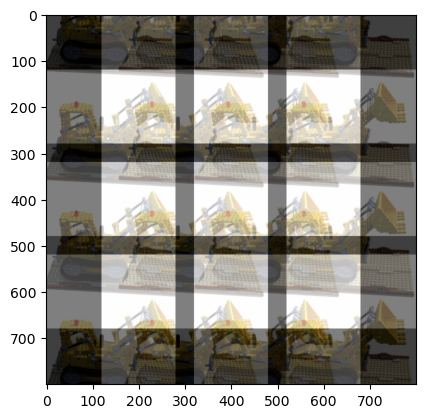

In [ ]:
"/home/w/757/multiplexed-pixels/plenoxels/blender_data/lego_gen12/train_multilens_16_black"
rendered_views_path = '/home/wl757/multiplexed-pixels/plenoxels/jax_logs10/original2/multilens16_5img_5679_and59'
dir_name = f"/home/wl757/multiplexed-pixels/plenoxels/blender_data/lego_gen12/multilens_16_dls_{d_lens_sensor}_5views_sensor800_img5679_and59"
selected_views = [50,59,60,70,90]

def get_rays_per_pixel(H,W, comap_yx):
    per_pixel = np.zeros((sensor_size,sensor_size,MAX_PER_PIXEL,3)).astype(np.uint32)
    mask = np.zeros((sensor_size,sensor_size,MAX_PER_PIXEL)).astype(float)
    cnt = np.zeros((sensor_size,sensor_size)).astype(np.uint8)
    for a in range(sensor_size):
        for b in range(sensor_size):
            for l in range(NUM_LENS):
                x=comap_yx[l, b, a, 1]
                y=comap_yx[l, b, a, 0]

                if x!=-1 and y!=-1:
                    per_pixel[a,b, cnt[a,b]] = np.array([x,y, l])
                    mask[a,b, cnt[a,b]] = 1.
                    cnt[a,b]+=1
    return per_pixel, mask, cnt

def max_overlapping_pixels(comap_yx):
    maps_pixel_to_rays, mask, cnt_mpp = get_rays_per_pixel(sensor_size,sensor_size, comap_yx)
    rgb = np.zeros((sensor_size,sensor_size,3))
    sub_pixels = np.zeros((sensor_size,sensor_size,MAX_PER_PIXEL,3))
    cnt_pixels = np.zeros((sensor_size,sensor_size)).astype(np.int)
    for i_index in range(sensor_size):
        for j_index in range(sensor_size):
            for cnt_rays in range(maps_pixel_to_rays.shape[2]): # over MAX_PER_PIXEL
                x_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,0] #height
                y_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,1] #width
                l_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,2] #lens

                cnt = cnt_pixels[i_index, j_index]
                sub_pixels[i_index, j_index, cnt] = np.array([x_index, y_index, l_index])
                cnt_pixels[i_index, j_index] += 1
    return sub_pixels, cnt_pixels

def generate(comap_yx,base):
    maps_pixel_to_rays, mask, cnt_mpp = get_rays_per_pixel(sensor_size,sensor_size, comap_yx)
    u = int(np.max(comap_yx[0,:,:,:], axis=(0,1,2)) +1)
    sub_lens = np.zeros((NUM_LENS,u,u,3))

    for j in range(NUM_LENS):
        im_gt = imageio.imread(f'{rendered_views_path}/r_{base}_{j}.png').astype(np.float32) / 255.0 
#             im_gt = imageio.imread(f'/home/vitran/plenoxels/output_multilens_16json/renaming/r_{base}_{j}.png').astype(np.float32) / 255.0 
#             im_gt = imageio.imread(f"/home/vitran/plenoxels/jax_logs10/original2/r_{base}_{j}.png").astype(np.float32) / 255.0 #multilens 100
        a = int(np.max(comap_yx[0,:,:,:], axis=(0,1,2)))+1
        im_gt = resize(im_gt, (a,a), anti_aliasing=True)
        sub_lens[j,:,:,:] = im_gt[:,:,:3]
        
    rgb = np.zeros((sensor_size,sensor_size,3)).astype(float)
    cnt_subpixels = np.zeros((sensor_size,sensor_size), dtype=int)
    
    for i_index in range(sensor_size):
        for j_index in range(sensor_size):
            for cnt_rays in range(maps_pixel_to_rays.shape[2]): # over MAX_PER_PIXEL
                x_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,0] #height
                y_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,1] #width
                l_index = maps_pixel_to_rays[i_index, j_index,cnt_rays,2] #lens
                if mask[i_index, j_index,cnt_rays]==1:
                    rgb[i_index, j_index] += sub_lens[l_index, x_index, y_index,:]
                    cnt_subpixels[i_index, j_index] +=1
            rgb[i_index,j_index] = rgb[i_index,j_index] / MAX_PER_PIXEL 
    rgb = np.concatenate((rgb, np.ones((sensor_size,sensor_size,1))), axis=2)
    return rgb

os.makedirs(dir_name, exist_ok=True)
for base in selected_views:
    rgb = generate(comap_yx, base)
    rgb = Image.fromarray((rgb*255).astype('uint8')) #(a*255).astype('uint8'))
    plt.imshow(rgb)
    rgb.save(f"{dir_name}/r_{base}.png")

Generate the json file points to the newly generated multiplexed images

In [4]:
# file = open('/home/vitran/plenoxels/blender_data/lego_gen10/transforms_train_multilens_100.json')
file = open('/home/vitran/plenoxels/blender_data/lego_gen12/transforms_train_multilens_16_black.json')
#              /home/vitran/plenoxels/blender_data/lego_gen12/transforms_train_multilens_16_5views_img5679_and59.json
org_json = json.load(file)
new_frames = []
for i, frame in enumerate(org_json['frames']):
    index =  frame['file_path'].split('/')[-1]
    frame['file_path'] = f'./train_multilens_16_wide/{index}'
    new_frames.append(frame)
file.close()

file.close()
org_json['frames'] = new_frames
with open(f'/home/vitran/plenoxels/blender_data/lego_gen12/transforms_train_multilens_16_wide.json','w') as f:
    json.dump(org_json, f)

In [3]:
# file = open('/home/vitran/plenoxels/blender_data/lego_gen10/transforms_train_multilens_100.json')
file = open('/home/vitran/plenoxels/blender_data/lego/transforms_test.json')
#              /home/vitran/plenoxels/blender_data/lego_gen12/transforms_train_multilens_16_5views_img5679_and59.json
org_json = json.load(file)
new_frames = []
for i, frame in enumerate(org_json['frames']):
    
    index =  frame['file_path'].split('/')[-1]
    frame['file_path'] = f'./test_focal/{index}'
    new_frames.append(frame)
file.close()

file.close()
org_json['frames'] = new_frames
org_json['camera_angle_x'] = 0.9
with open(f'/home/vitran/plenoxels/blender_data/lego_gen12/transforms_test_focal.json','w') as f:
    json.dump(org_json, f)

In [19]:
for i in range(100):
    path = f'/home/vitran/plenoxels/blender_data/lego_gen12/train_multilens_100_copy/r_0_{i}.png'
    img = imageio.imread(f'{path}')
    imageio.imwrite(f'/home/vitran/plenoxels/blender_data/lego_gen12/train_multilens_100/r_90_{i}.png', img)

4x4: Distance 10:Average Psnr 21.936517163329633

4x4: Distance 15:Average Psnr 22.22421984151104

4x4: Distance 18:Average Psnr 22.321036987069984

4x4: Distance 20:Average Psnr 21.20406898877371

10x10: Distance 10:Average Psnr 19.659256173606128

10x10: Distance 12:Average Psnr 18.91093249190484

10x10: Distance 14:Average Psnr 19.26252170366399

10x10: Distance 18:Average Psnr 19.68656544565571

10x10: Distance 25:Average Psnr 14.610425786842605



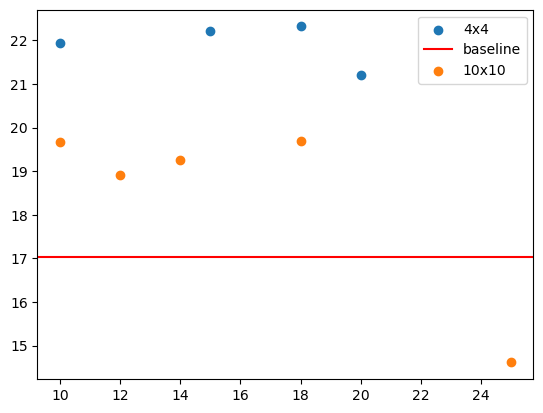

In [39]:
xaxis = [10,15,18,20]
yaxis = []
for dls in xaxis:
    path = f'/home/vitran/plenoxels/jax_logs12/dls_psnr_multiplex16_dls_{dls}_5views_sensor800_img5679_and59_epoch/log.txt'
    with open(path) as f:
        lines = f.readlines()
        print(f'4x4: Distance {dls}:{lines[-1]}')
        yaxis.append(float(lines[-1].split(' ')[-1]))
plt.scatter(xaxis, yaxis, label='4x4')
plt.axhline(y=17.021165017950217, color='r', linestyle='-', label='baseline')
# plt.title('grid of 4x4 sublens')

xaxis = [10,12,14,18,25]
yaxis = []
for dls in xaxis:
    path = f'/home/vitran/plenoxels/jax_logs11/dls_psnr_multiplex100_dls_{dls}_5views_sensor800_img5679_and_59/log.txt'
    with open(path) as f:
        lines = f.readlines()
        print(f'10x10: Distance {dls}:{lines[-1]}')
        yaxis.append(float(lines[-1].split(' ')[-1]))
plt.scatter(xaxis, yaxis, label='10x10')
plt.legend()
# plt.title('grid of 10x10 sublens')

Average Psnr 19.659256173606128

Average Psnr 18.91093249190484

Average Psnr 19.26252170366399

Average Psnr 19.68656544565571

Average Psnr 14.610425786842605



Text(0.5, 1.0, 'grid of 10x10 sublens')

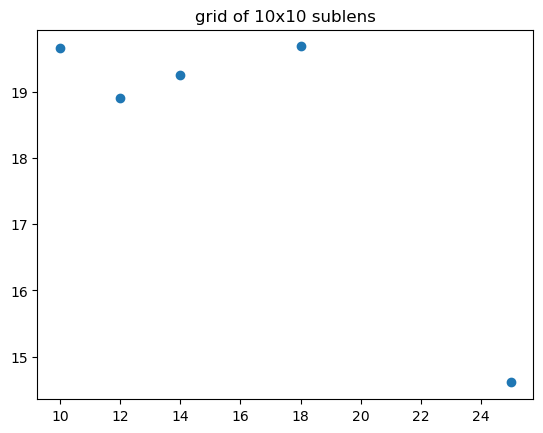

In [30]:
xaxis = [10,12,14,18,25]
yaxis = []
for dls in xaxis:
    path = f'/home/vitran/plenoxels/jax_logs11/dls_psnr_multiplex100_dls_{dls}_5views_sensor800_img5679_and_59/log.txt'
    with open(path) as f:
        lines = f.readlines()
        print(lines[-1])
        yaxis.append(float(lines[-1].split(' ')[-1]))
plt.scatter(xaxis, yaxis)
plt.title('grid of 10x10 sublens')